In [49]:
import tensorflow as tf 
from tensorflow.keras import datasets,layers,models

print(tf.__version__)

BATCH_SIZE = 100

def load_image(img_path,size = (32,32)):
    print(img_path)
    label = tf.constant(1,tf.int8) if tf.strings.regex_full_match(img_path,".*/automobile/.*") \
            else tf.constant(0,tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) #注意此处为jpeg格式
    img = tf.image.resize(img,size)/255.0
    print(label)
    return(img,label)



2.1.0


In [50]:
#使用并行化预处理num_parallel_calls 和预存数据prefetch来提升性能
ds_train = tf.data.Dataset.list_files("G:/Data/cifar/train/*/*.jpg").map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

ds_test = tf.data.Dataset.list_files("G:/Data/cifar/test/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)


Tensor("args_0:0", shape=(), dtype=string)
Tensor("cond/Identity:0", shape=(), dtype=int8)
Tensor("args_0:0", shape=(), dtype=string)
Tensor("cond/Identity:0", shape=(), dtype=int8)


tf.Tensor(0, shape=(), dtype=int8)
tf.Tensor(0, shape=(), dtype=int8)
tf.Tensor(0, shape=(), dtype=int8)
tf.Tensor(0, shape=(), dtype=int8)
tf.Tensor(0, shape=(), dtype=int8)
tf.Tensor(0, shape=(), dtype=int8)
tf.Tensor(0, shape=(), dtype=int8)
tf.Tensor(0, shape=(), dtype=int8)
tf.Tensor(0, shape=(), dtype=int8)


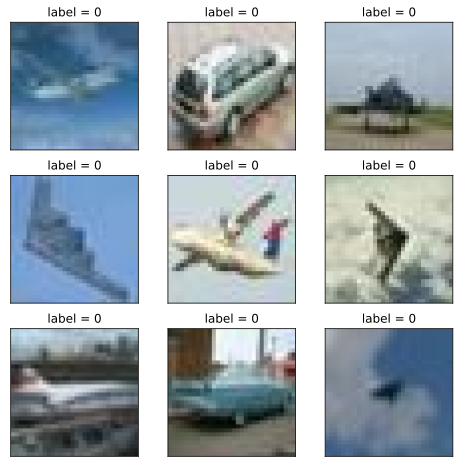

In [51]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i,(img,label) in enumerate(ds_test.unbatch().take(9)):
    ax=plt.subplot(3,3,i+1)
    print(label)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [47]:
for x,y in ds_train.take(2):
    print(x.shape,y.shape)
    print(y)

(100, 32, 32, 3) (100,)
tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(100,), dtype=int8)
(100, 32, 32, 3) (100,)
tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(100,), dtype=int8)


In [52]:
tf.keras.backend.clear_session() #清空会话

inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32,kernel_size=(3,3))(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64,kernel_size=(5,5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

model = models.Model(inputs = inputs,outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0     

In [56]:
import datetime

#logdir = "./data/keras_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#logdir = "./data/keras_model/" 
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.binary_crossentropy,
        metrics=["accuracy"]
    )

history = model.fit(ds_train,epochs= 10,validation_data=ds_test,workers = 4)

Train for 100 steps, validate for 20 steps
Epoch 1/10
100/100 [==============================] - 17s 169ms/step - loss: 2.3622e-04 - accuracy: 1.0000 - val_loss: 8.2283e-14 - val_accuracy: 1.0000
Epoch 2/10
100/100 [==============================] - 4s 41ms/step - loss: 1.9284e-12 - accuracy: 1.0000 - val_loss: 8.2127e-14 - val_accuracy: 1.0000
Epoch 3/10
100/100 [==============================] - 4s 43ms/step - loss: 1.5847e-12 - accuracy: 1.0000 - val_loss: 8.2127e-14 - val_accuracy: 1.0000
Epoch 4/10
100/100 [==============================] - 4s 43ms/step - loss: 1.3050e-12 - accuracy: 1.0000 - val_loss: 8.2127e-14 - val_accuracy: 1.0000
Epoch 5/10
100/100 [==============================] - 5s 45ms/step - loss: 1.2164e-12 - accuracy: 1.0000 - val_loss: 8.2127e-14 - val_accuracy: 1.0000
Epoch 6/10
100/100 [==============================] - 4s 45ms/step - loss: 1.4273e-12 - accuracy: 1.0000 - val_loss: 8.2127e-14 - val_accuracy: 1.0000
Epoch 7/10
100/100 [=============================

In [57]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

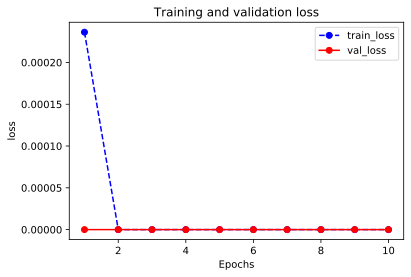

In [58]:
plot_metric(history,"loss")

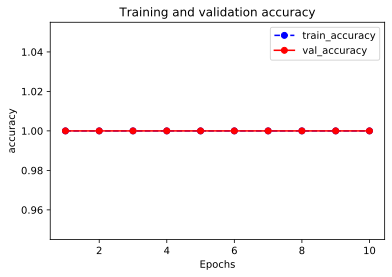

In [59]:
plot_metric(history,"accuracy")

In [60]:
#可以使用evaluate对数据进行评估
val_loss,val_accuracy = model.evaluate(ds_test,workers=4)
print(val_loss,val_accuracy)

20/20 [==============================] - 1s 35ms/step - loss: 8.2126e-14 - accuracy: 1.0000
8.21263700354958e-14 1.0


In [61]:
model.predict(ds_test)

array([[5.2729915e-37],
       [0.0000000e+00],
       [0.0000000e+00],
       ...,
       [8.8329936e-29],
       [1.5043477e-38],
       [2.4675593e-21]], dtype=float32)

In [62]:
for x,y in ds_test.take(1):
    print(model.predict_on_batch(x[0:20]))

tf.Tensor(
[[0.0000000e+00]
 [0.0000000e+00]
 [2.6713659e-37]
 [4.2679333e-38]
 [1.2480245e-29]
 [2.9938622e-32]
 [1.3278667e-29]
 [2.3310732e-30]
 [5.9027597e-25]
 [0.0000000e+00]
 [3.0677977e-38]
 [3.4639587e-31]
 [9.1598168e-27]
 [7.2980785e-35]
 [2.8531568e-33]
 [9.9279679e-32]
 [0.0000000e+00]
 [3.0391236e-36]
 [1.5891336e-21]
 [3.6123019e-27]], shape=(20, 1), dtype=float32)


In [63]:
# 保存权重，该方式仅仅保存权重张量
model.save_weights('./data/tf_model_weights.ckpt',save_format = "tf")

In [65]:

model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel')
model_loaded.evaluate(ds_test)

INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel\assets
export saved model.
20/20 [==============================] - 1s 39ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]